Enter full path of wind speed CSV file:  wind-speeds.csv



✅ Wind speed file loaded.
📄 Columns: ['north_sea_m_s']
📊 Dataset overview:
        north_sea_m_s
count    8760.000000
mean        7.838868
std         2.601923
min         1.810000
25%         6.036000
50%         7.680500
75%         9.310000
max        17.893000



Enter wind measurement height (in meters):  10
Enter surface roughness length (in meters):  0.0003
Enter hub height of turbine (in meters):  150



✅ Wind speed adjusted to hub height.
📄 New columns: ['north_sea_m_s_150m']



Enter full path of power curve CSV file (binned):  power curve.csv



✅ Power curve file loaded. Columns: ['min_speed', 'max_speed', 'power_MW']

✅ Power output columns created.
📊 Power columns: ['north_sea_m_s_150m_power_MW']

🔋 Annual Energy Yield from north_sea_m_s_150m_power_MW: 20951.80 MWh

📊 === Energy Yield Summary ===

📅 Monthly energy yield (MWh):
            north_sea_m_s_150m_power_MW
time                                   
2019-01-31                       2124.2
2019-02-28                       1657.0
2019-03-31                       2102.4
2019-04-30                       1514.6
2019-05-31                       1678.4
2019-06-30                       1220.8
2019-07-31                       1610.8
2019-08-31                       1305.0
2019-09-30                       1808.6
2019-10-31                       1908.4
2019-11-30                       1798.2
2019-12-31                       2223.4


C:\Users\lavee\AppData\Local\Temp\ipykernel_448\1615489414.py:76: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sum = df[power_col].resample('M').sum() * time_diff_hours


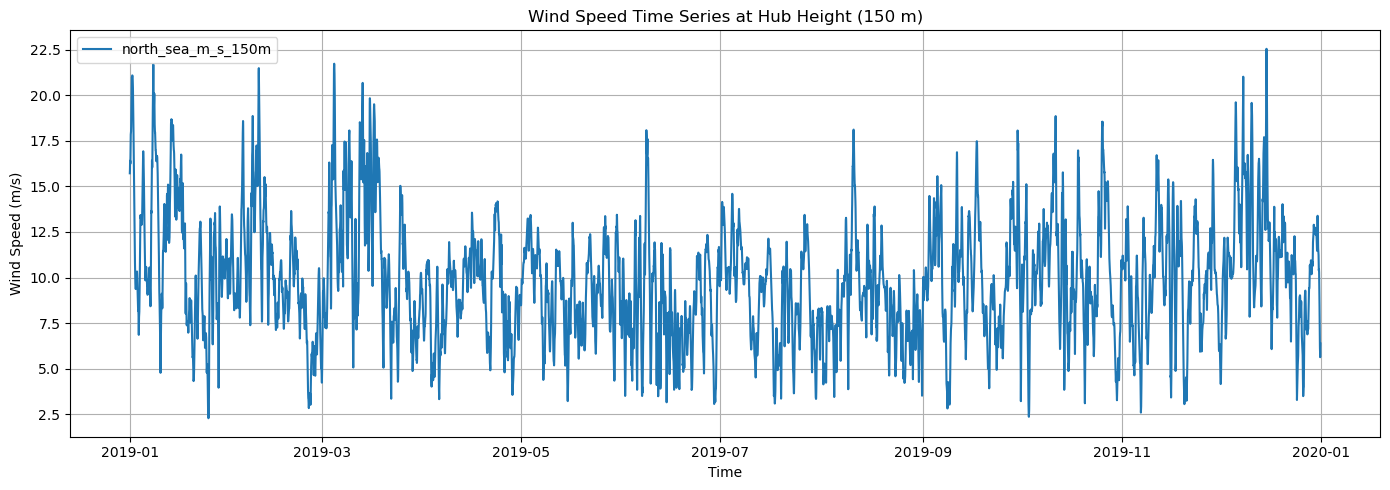

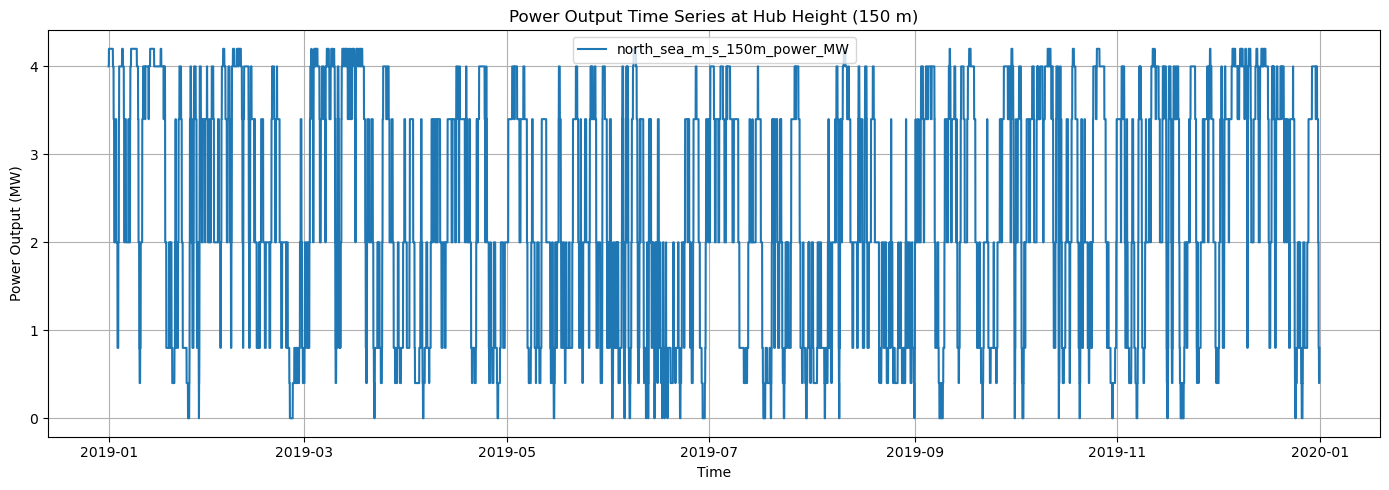

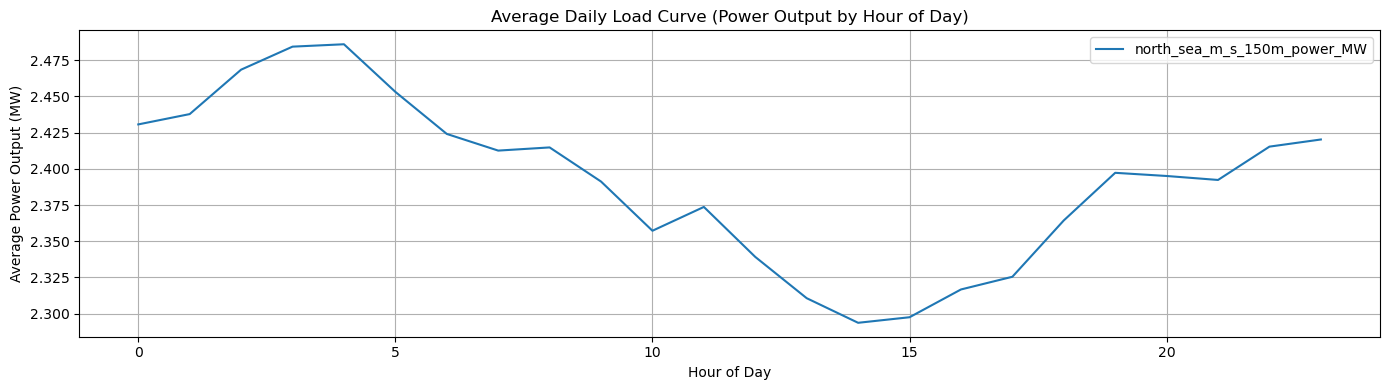

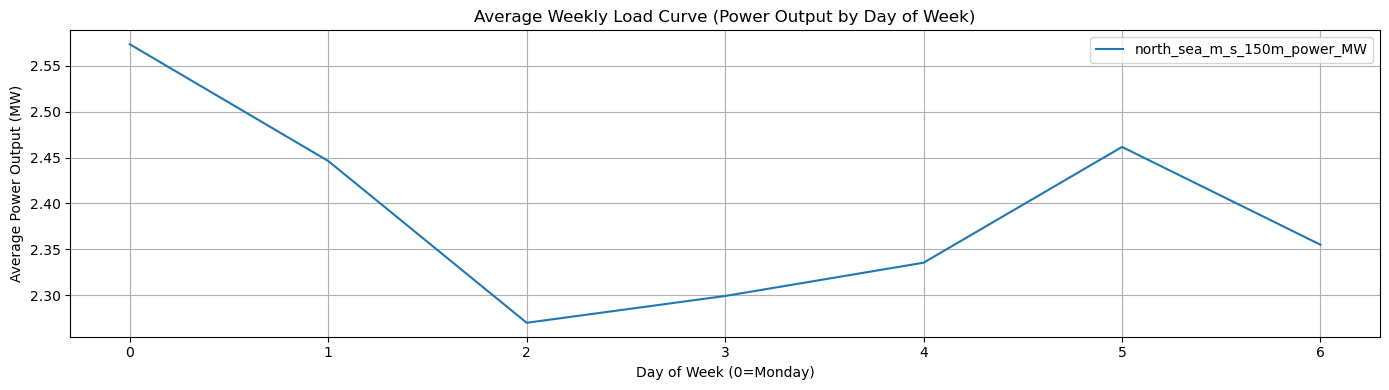

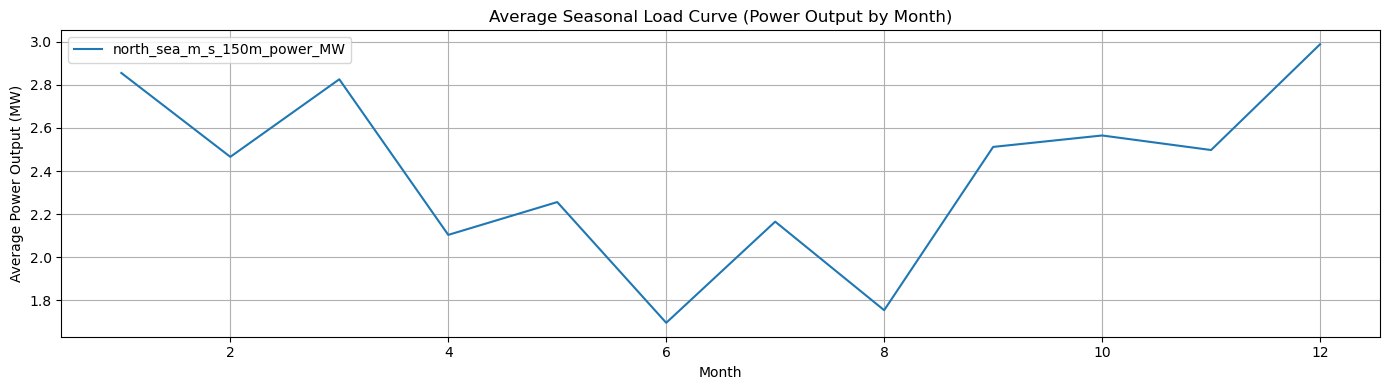

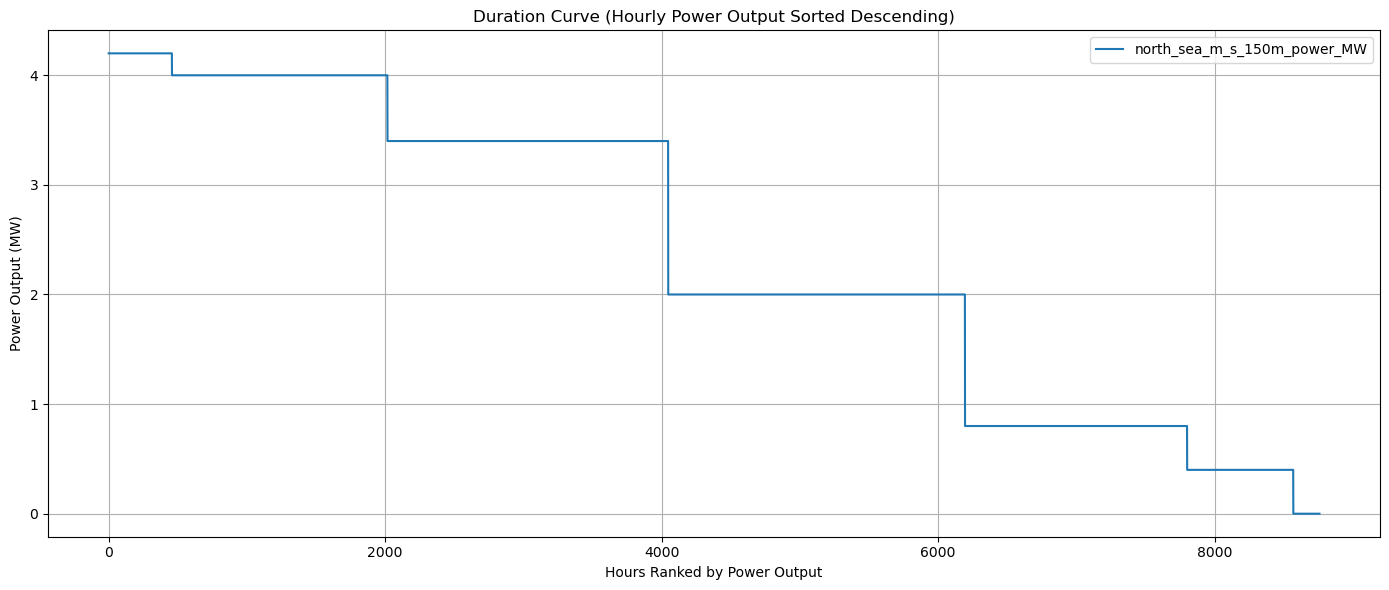


🔍 You can now explore daily power output time series.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load anual wind speed Time Series csv file (file name with file extension)
wind_file = input("Enter full path of wind speed CSV file: ").strip()
df = pd.read_csv(wind_file, index_col=0, parse_dates=True)

print("\n✅ Wind speed file loaded.")
print("📄 Columns:", df.columns.tolist())
print("📊 Dataset overview:\n", df.describe())

# step 2: user inputs
measurement_height = float(input("\nEnter wind measurement height (in meters): "))
roughness_length = float(input("Enter surface roughness length (in meters): "))
hub_height = float(input("Enter hub height of turbine (in meters): "))

# Step 3:logarithmic wind profile to estimate wind speed at hub height
def adjust_wind_speed(measured_speed):
    return measured_speed * (np.log(hub_height / roughness_length) / np.log(measurement_height / roughness_length))

# Step 4: columns for hub-height wind speeds
for col in df.columns:
    df[f"{col}_{int(hub_height)}m"] = df[col].apply(adjust_wind_speed)

print("\n✅ Wind speed adjusted to hub height.")
print("📄 New columns:", [col for col in df.columns if f"_{int(hub_height)}m" in col])

# Step 5: Load power curve
power_curve_file = input("\nEnter full path of power curve CSV file (binned): ").strip()
power_df = pd.read_csv(power_curve_file)

print("\n✅ Power curve file loaded. Columns:", list(power_df.columns))

# Check correct format
required_cols = {'min_speed', 'max_speed', 'power_MW'}
if not required_cols.issubset(power_df.columns):
    raise ValueError("Power curve CSV must contain: min_speed, max_speed, power_MW")

# Step 6: lookup function based on binned power curve
def get_power_from_bins(ws):
    for _, row in power_df.iterrows():
        if row['min_speed'] <= ws < row['max_speed']:
            return row['power_MW']
    return 0  # If no bin matched

# Step 7: power curve to each hub-height wind speed column
power_columns = []
for col in df.columns:
    if f"_{int(hub_height)}m" in col and not col.endswith('_power_MW'):
        power_col_name = f"{col}_power_MW"
        df[power_col_name] = df[col].apply(get_power_from_bins)
        power_columns.append(power_col_name)

print("\n✅ Power output columns created.")
print("📊 Power columns:", power_columns)

# Step 8: Calculate annual energy yield in MWh 
time_diff_hours = (df.index[1] - df.index[0]).total_seconds() / 3600

for power_col in power_columns:
    total_energy_MWh = df[power_col].sum() * time_diff_hours
    print(f"\n🔋 Annual Energy Yield from {power_col}: {total_energy_MWh:.2f} MWh")

# ======== Additional Analysis & Visualization ========

import seaborn as sns

print("\n📊 === Energy Yield Summary ===")

# Monthly energy yield table
print("\n📅 Monthly energy yield (MWh):")
monthly_energy = {}
for power_col in power_columns:
    monthly_sum = df[power_col].resample('M').sum() * time_diff_hours
    monthly_energy[power_col] = monthly_sum

monthly_energy_df = pd.DataFrame(monthly_energy)
print(monthly_energy_df)

# 1. Wind Speed Time Series at Hub Height
plt.figure(figsize=(14,5))
for col in df.columns:
    if f"_{int(hub_height)}m" in col and not col.endswith('_power_MW'):
        plt.plot(df.index, df[col], label=col)
plt.title(f"Wind Speed Time Series at Hub Height ({int(hub_height)} m)")
plt.xlabel("Time")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Power Output Time Series at Hub Height
plt.figure(figsize=(14,5))
for power_col in power_columns:
    plt.plot(df.index, df[power_col], label=power_col)
plt.title(f"Power Output Time Series at Hub Height ({int(hub_height)} m)")
plt.xlabel("Time")
plt.ylabel("Power Output (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Load Curve: Daily, Weekly, Seasonal patterns

# Daily average power profile (mean power for each hour of day)
plt.figure(figsize=(14,4))
for power_col in power_columns:
    daily_profile = df[power_col].groupby(df.index.hour).mean()
    plt.plot(daily_profile.index, daily_profile, label=power_col)
plt.title("Average Daily Load Curve (Power Output by Hour of Day)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Power Output (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekly average power profile (mean power by day of week)
plt.figure(figsize=(14,4))
for power_col in power_columns:
    weekly_profile = df[power_col].groupby(df.index.dayofweek).mean()
    plt.plot(weekly_profile.index, weekly_profile, label=power_col)
plt.title("Average Weekly Load Curve (Power Output by Day of Week)")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Average Power Output (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal (monthly) average power profile
plt.figure(figsize=(14,4))
for power_col in power_columns:
    monthly_profile = df[power_col].groupby(df.index.month).mean()
    plt.plot(monthly_profile.index, monthly_profile, label=power_col)
plt.title("Average Seasonal Load Curve (Power Output by Month)")
plt.xlabel("Month")
plt.ylabel("Average Power Output (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Duration Curve (power output sorted descending)
plt.figure(figsize=(14,6))
for power_col in power_columns:
    sorted_power = df[power_col].sort_values(ascending=False).reset_index(drop=True)
    plt.plot(sorted_power.index, sorted_power, label=power_col)
plt.title("Duration Curve (Hourly Power Output Sorted Descending)")
plt.xlabel("Hours Ranked by Power Output")
plt.ylabel("Power Output (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from scipy.stats import linregress

print("\n🔍 You can now explore daily power output time series.")

while True:
    date_input = input("\nEnter a date to view power output (YYYY-MM-DD) or type 'quit' to exit: ").strip()
    if date_input.lower() in ['quit', 'exit']:
        print("Exiting daily power output explorer.")
        break

    try:
        # Parse date input
        day = pd.to_datetime(date_input).normalize()
        next_day = day + pd.Timedelta(days=1)

        # Filter data for that day
        day_df = df[(df.index >= day) & (df.index < next_day)]

        if day_df.empty:
            print("No data available for this date. Please try another date.")
            continue

        plt.figure(figsize=(14,6))
        for power_col in power_columns:
            y = day_df[power_col]
            x = np.arange(len(y))  # time points as integers for regression

            # Plot power output time series
            plt.plot(day_df.index, y, label=f"{power_col} Output")

            # Calculate and plot trend line (linear regression)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            trend_line = intercept + slope * x
            plt.plot(day_df.index, trend_line, linestyle='--', label=f"{power_col} Trend line")

        plt.title(f"Power Output Time Series and Trend Line on {date_input}")
        plt.xlabel("Time")
        plt.ylabel("Power Output (MW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}. Please enter a valid date format (YYYY-MM-DD).")





# Optional: Save to file
save_path = input("\nDo you want to save the full dataset with power output? (y/n): ").strip().lower()
if save_path == 'y':
    output_file = input("Enter full output CSV path to save: ").strip()
    df.to_csv(output_file)
    print(f"\n💾 File saved to: {output_file}")






In [ ]:
#D:\Assignments\power curve.csv

In [ ]:
#D:\Assignments\wind-speeds.csv


🔍 You can now explore daily power output time series.



Enter a date to view power output (YYYY-MM-DD) or type 'quit' to exit:  2019-06-30 


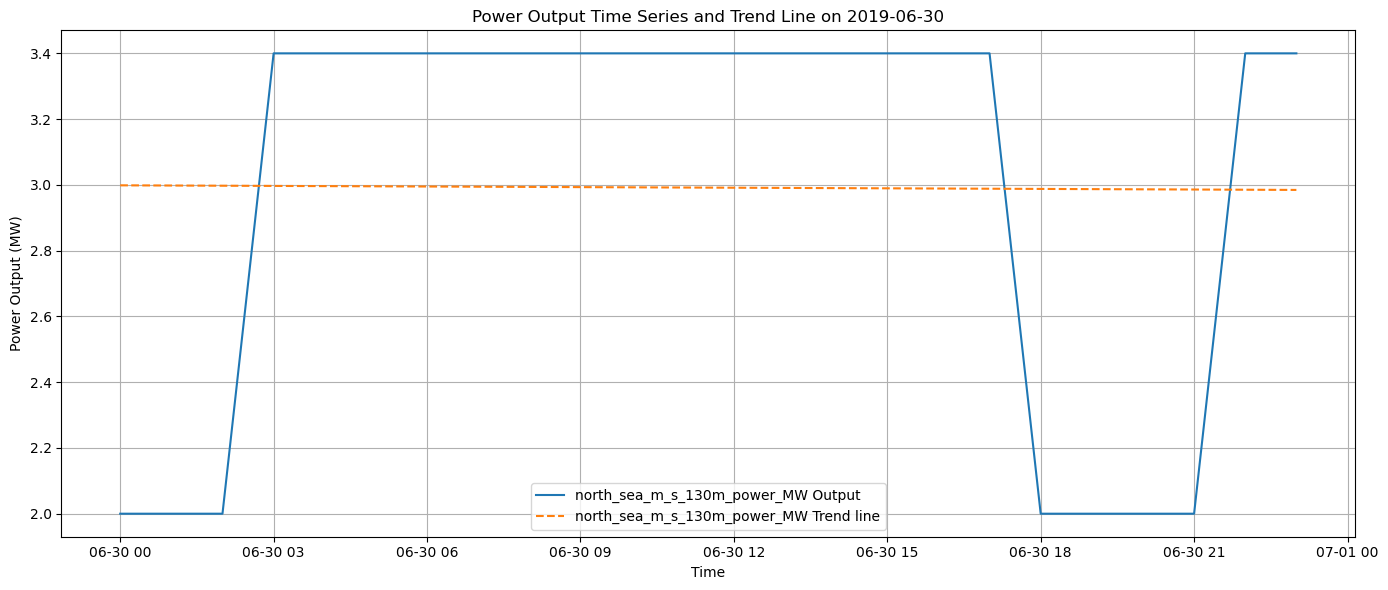


Enter a date to view power output (YYYY-MM-DD) or type 'quit' to exit:  2019-04-15 


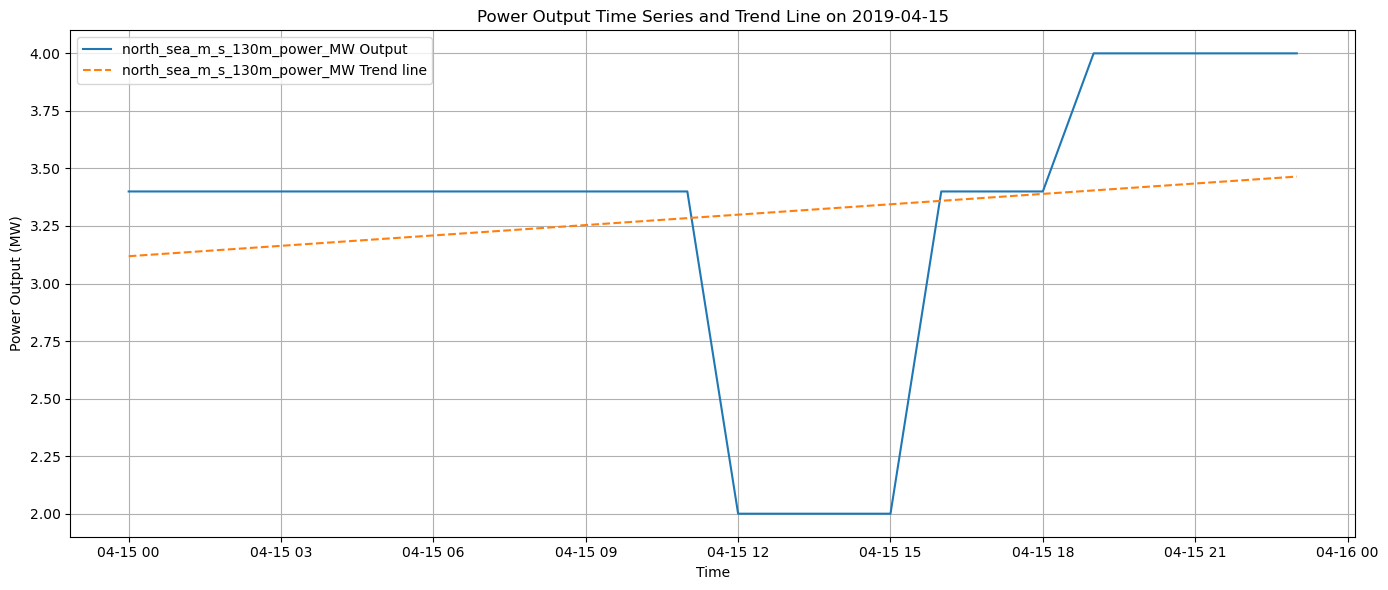


Enter a date to view power output (YYYY-MM-DD) or type 'quit' to exit:  exit


Exiting daily power output explorer.
